[View in Colaboratory](https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeper/deeperfont_data_preparation.ipynb)

Import TTF fonts and output training data: a series of point deltas (dx, dy) along with booleans for pen-up/pen-down and next-glyph.

In [334]:
#jupyter notebook    --NotebookApp.allow_origin='https://colab.research.google.com'    --port=8888
from enum import Enum, IntEnum
import math
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageDraw, ImageChops, ImageFont
from IPython.display import display
import tensorflow as tf
print(np.__version__)
print(tf.__version__)
np.set_printoptions(precision=2)
tf.enable_eager_execution()
from google.colab import drive


1.14.2
1.10.0


ValueError: ignored

In [0]:
#Read Font outlines from local font files and write outlines to file for fitting
from fontTools.ttLib import TTFont  #pip install fonttools

def getCoordinates(font:TTFont, glyphName:str):
    """font, glyphName --> glyph coordinates as expected by "gvar" table
    The result includes four "phantom points" for the glyph metrics,
    as mandated by the "gvar" spec.
    Function from https://github.com/fonttools/fonttools/blob/master/Snippets/interpolate.py
    By inspection coords[0] are all points, and coords[1] are the end of the ranges for each contour (shape)
    """
    glyphTable = font["glyf"]
    glyph = glyphTable.glyphs.get(glyphName)
    if glyph is None:
        return None
    glyph.expand(glyphTable)
    glyph.recalcBounds(glyphTable)
    coords = glyph.getCoordinates(glyphTable)
    start=0
    contours = []
    for end in coords[1]:
        contours.append(coords[0][start:end+1])
        start=end+1
    return contours

class Stroke(IntEnum):
    """
    Enum defining data contents of last dimension
    """
    DX = 0
    DY = 1
    PenDown = 2  # +1 draw stroke, 0 if this stroke is hidden, i.e. to move between contours in the glyph
    EndOfGlyph = 3  # +1 indicates this stroke is the last of the current glyph, else 0
    Size = 4  # size of this enum
    
def generateOutlines(fontfile:str, glyphs:str, max_outline_points:int):
    """
    Read the actual points from all glyphs in the font into numpy array.
    Output is array of glyphs x points x 2 (angle in radians, distance).
    We use float not the original ints from the font - according to https://github.com/fchollet/keras/issues/2218.
    """
    font = TTFont(fontfile)
    unitsPerEm = font['head'].unitsPerEm *0.7
    outlines = np.zeros((max_outline_points, Stroke.Size), np.float32)
    j = 0
    for i, letter in enumerate(glyphs):
        contours = getCoordinates(font, letter)
        startp = (0,0)
        #ttx contours are areas within the glyph, like the outside and inside outlines of an O
        for xy in contours:
            #fill output matrix, start with hidden line to start position
            outlines[j,Stroke.DX] = (xy[0][0]-startp[0])/ unitsPerEm
            outlines[j,Stroke.DY] = (xy[0][1]-startp[1])/ unitsPerEm
            outlines[j,Stroke.PenDown] = 0
            j = j+1
            if j>=max_outline_points: break
            startp = xy[0]
            #then between points
            for n in range(len(xy)-1):
                outlines[j,Stroke.DX] = (xy[n+1][0]-xy[n][0])/ unitsPerEm
                outlines[j,Stroke.DY] = (xy[n+1][1]-xy[n][1])/ unitsPerEm
                outlines[j,Stroke.PenDown] = 1
                j = j+1
                if j>=max_outline_points: break
            #finally wrap last point to first in contour
            outlines[j,Stroke.DX] = (xy[0][0]-xy[-1][0])/ unitsPerEm
            outlines[j,Stroke.DY] = (xy[0][1]-xy[-1][1])/ unitsPerEm
            outlines[j,Stroke.PenDown] = 1
            j = j+1
            if j>=max_outline_points: break
        outlines[j-1,Stroke.EndOfGlyph] = 1  # otherwise leave as 0
    print("Font %s has %d points" % (fontfile, j))
    return outlines
  
def readFonts(files: [str], glyphs: str, max_outline_points:int):
    print('loading {} files'.format(len(files)))
    outlines = []
    for i, fontfile in enumerate(files):
        outlines.append(generateOutlines(fontfile, glyphs, max_outline_points))
    return np.stack(outlines)


In [0]:
def drawOutlines(outlines, cellsize, glyphCount):
  """Draw outline tensor."""
  im = Image.new('1', size=(glyphCount*cellsize, outlines.shape[0]*cellsize), color=(0))
  def drawPoints(im, points):
    if len(points)<=2:
      return im
    #temporary image to use to xor each part with main image
    im2 = Image.new('1', size=(glyphCount*cellsize, outlines.shape[0]*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im2).polygon(points, fill=1)
    return ImageChops.logical_xor(im, im2)
  scale = cellsize * 0.9
  for font in range(outlines.shape[0]):
    i = 0
    for glyphNum in range(glyphCount):
      points = []
      x,y = (glyphNum * cellsize, (font+1) * cellsize)
      #ImageDraw.Draw(im).line((glyphNum * cellsize, font * cellsize, glyphNum * cellsize, (font+1) * cellsize), fill=1)
      #ImageDraw.Draw(im).line((glyphNum * cellsize, font * cellsize, (glyphNum+1) * cellsize, font * cellsize), fill=1)
      while True:
        x += outlines[font,i,Stroke.DX]*scale
        y -= outlines[font,i,Stroke.DY]*scale
        #print(outlines[font,i], x,y)
        if outlines[font,i,Stroke.PenDown]>0.5:
          points += (x,y)
        else:
          im = drawPoints(im, points)
          points=[(x,y)]
        i+=1
        if outlines[font,i-1,Stroke.EndOfGlyph]>0.5 or i>=outlines.shape[1]:
          break
      im = drawPoints(im, points)
  return im


In [0]:
def outlinesToScanlines(outlines, max_points_per_scanline, ygrid, glyphCount):
    '''
    Pure tensorflow function
    Input: 2D tensor of max_outline_points * Stroke (DX,DY,PenDown,EndOfGlyph)
    Output: glyphCount * y coord * sorted x coords for each scanline
    '''
    glyphNums = tf.cast(outlines[:-1,Stroke.EndOfGlyph]>0.5, tf.int32)
    glyphNums = tf.cumsum(glyphNums, axis=-1)
    glyphNums = tf.concat((tf.zeros([1], dtype=tf.int32), glyphNums), axis=0)
    glyphNums2D = tf.expand_dims(tf.range(glyphCount),-1)
    glyphNums2D = tf.tile(glyphNums2D, [1,glyphNums.shape[0]])
    glyphNums2D = tf.math.equal(glyphNums2D, glyphNums)
    glyphNums2D = tf.cast(glyphNums2D, tf.float32)
    xs = tf.cumsum(outlines[:,Stroke.DX] * glyphNums2D, axis=1)+1e-2
    ys = tf.cumsum(outlines[:,Stroke.DY] * glyphNums2D, axis=1)+1e-2
    #offset to create line start x1,y1 to end x2,y2
    #add 3rd dimension (size=1) so following interpolation in y is broadcast across all lines
    x1s = tf.expand_dims(xs[:,:-1], -1)
    x2s = tf.expand_dims(xs[:,1:], -1)
    y1s = tf.expand_dims(ys[:,:-1], -1)
    y2s = tf.expand_dims(ys[:,1:], -1)
    #linear interpolate the x coords for all lines at all y coord
    xxs = x1s + (x2s-x1s)*(ygrid-y1s)/(y2s-y1s)
    #zero x coords outside of line y bounds or where dy=0 and for hidden lines
    in_range = tf.logical_or(tf.logical_and(y1s<ygrid, ygrid<=y2s), tf.logical_and(y2s<ygrid, ygrid<=y1s))
    in_range = tf.logical_and(in_range, y2s!=y1s)
    visible = outlines[1:,Stroke.PenDown]>0.5
    in_range = tf.logical_and(in_range, tf.expand_dims(visible,-1))
    xxs = tf.where(in_range, xxs, tf.zeros_like(xxs)) 
    return tf.nn.top_k(tf.transpose(xxs, perm=(0,2,1)), max_points_per_scanline).values
  
def drawScanLines(xxs, ygrid, cellsize):
    '''Draw a glyph rasterisation based on a input y coord array with array of x-intercepts of lines with the y coord'''
    columns = math.ceil(1000/cellsize)
    rows = 1 #math.ceil(xxs.shape[0]/columns)
    scale = cellsize * 0.9
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im) 
    for i in range(xxs.shape[0]):
      yy,xx = divmod(i, columns)
      xx *= cellsize
      yy = (yy+1)*cellsize-1
      for xs, y in zip(xxs[i], ygrid):
        for j in range(0, xs.shape[0], 2):
          if(xs[j]>1e-5):
            if(xs[j+1]>1e-5):
              draw.line((xx+xs[j]*scale, yy-y*scale, xx+xs[j+1]*scale, yy-y*scale), fill=1)
            else:
              draw.ellipse((xx+xs[j]*scale-1, yy-y*scale-1, xx+xs[j]*scale+1, yy-y*scale+1), fill=1)
    return im  

setup...
loading 8 files
Font deeper/fonts\AndikaNewBasic-B.ttf has 2445 points
Font deeper/fonts\AndikaNewBasic-BI.ttf has 2871 points
Font deeper/fonts\AndikaNewBasic-I.ttf has 2876 points
Font deeper/fonts\AndikaNewBasic-R.ttf has 2462 points
Font deeper/fonts\Courier Prime Bold Italic.ttf has 4260 points
Font deeper/fonts\Courier Prime Bold.ttf has 4162 points
Font deeper/fonts\Courier Prime Italic.ttf has 3599 points
Font deeper/fonts\Courier Prime.ttf has 3551 points
outline shape (fonts, max_points_per_scanline, Stroke.Size):  (8, 5000, 4)


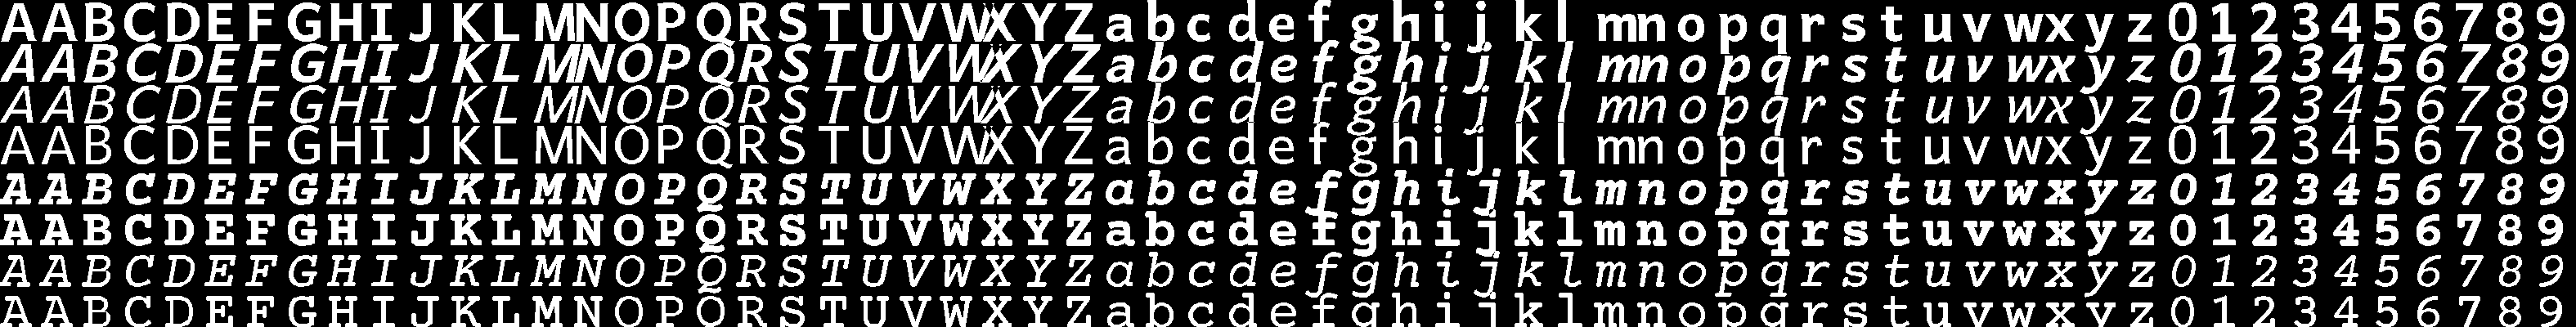

scanlines shape:  (63, 30, 10)


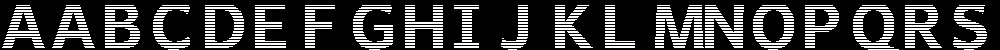

scanlines shape:  (63, 30, 10)


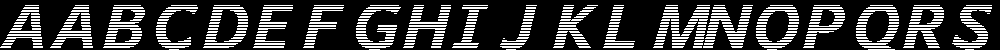

scanlines shape:  (63, 30, 10)


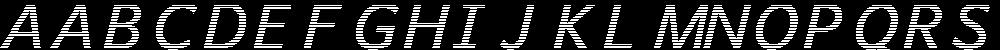

scanlines shape:  (63, 30, 10)


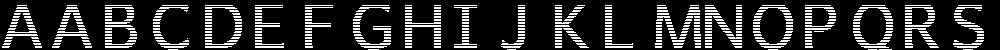

scanlines shape:  (63, 30, 10)


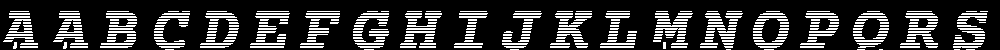

scanlines shape:  (63, 30, 10)


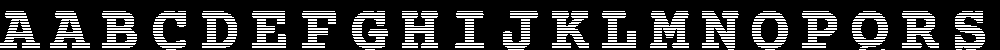

scanlines shape:  (63, 30, 10)


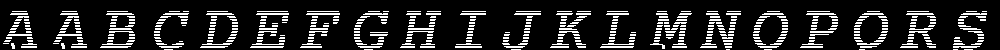

scanlines shape:  (63, 30, 10)


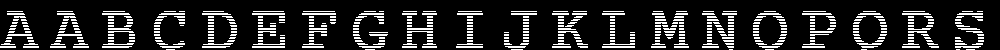

In [338]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
#glyphs = ['one','two','one','two']
glyphs = ['A'] + glyphs
max_points_per_scanline = 10 # required for g, m
max_outline_points = 5000
ygrid = np.linspace(0.0, 1.0, 30, endpoint=False) #y coordinates to render on
files = glob.glob('deeper/fonts/*.ttf')
outlines = readFonts(files, glyphs, max_outline_points)
testoutlines = tf.constant([[[0.2,0.2,0,0],[0.6,0,1,0],[0,0.6,1,0],[-0.6,0,1,0],[0,-0.6,1,1]]], dtype=tf.float32)
testoutlines = tf.tile(outlines, (1, 10, 1))
testglyphs = ['A'] * 10
print("outline shape (fonts, max_points_per_scanline, Stroke.Size): ", outlines.shape)
display(drawOutlines(outlines, cellsize, len(glyphs)))

#test the TF scanline algorithm
for i in range(outlines.shape[0]):
  scanlines = outlinesToScanlines(outlines[i], max_points_per_scanline, ygrid, len(glyphs))
  print("scanlines shape: ", scanlines.shape)
  display(drawScanLines(scanlines, ygrid, cellsize))

In [383]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


#drive.mount('/content/gdrive')
#with open('/content/gdrive/My Drive/fonts8.tfrecords', 'w') as f:
#  f.write('Hello Google Drive!')

filename = r'C:\src\notebooks\deeper\fonts\fonts8.tfrecords'
print('Writing', filename)
with tf.python_io.TFRecordWriter(filename) as writer:
  for index in range(outlines.shape[0]):
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'glyphNum': tf.train.Feature(int64_list=tf.train.Int64List(value=[len(glyphs)])),
          'outline': tf.train.Feature(float_list=tf.train.FloatList(value=outlines[index].flatten().tolist())),
        }))
    writer.write(example.SerializeToString())


Writing C:\src\notebooks\deeper\fonts\fonts8.tfrecords


In [411]:
def parse_proto(example_proto):
  features = {
    'glyphNum': tf.FixedLenFeature([1], tf.int64),
    'outline': tf.FixedLenFeature([5000*4], tf.float32),
  }
  return tf.parse_single_example(example_proto, features)

buffer_size=10000
batch_size=10
#dataset = tf.python_io.tf_record_iterator(filename)
dataset = tf.data.TFRecordDataset(filename)
print(dataset.output_types)
print(dataset.output_shapes)
# for d in dataset:
#   print(parse_proto(d))
dataset = dataset.map(parse_proto)
dataset = dataset.shuffle(buffer_size)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

assert next_element["glyphNum"].numpy()[0] == 63
assert next_element["outline"].shape[0].value == batch_size
assert next_element["outline"].shape[1].value == 20000

  

<dtype: 'string'>
()
